# Processing Many Exposures and Creating Light Curves

In the last tutorial, you learned:

* how to measure the calibrated magnitude of a target source in a single exposure
* how to make a cutout image of the target source

In this tutorial, you will now do these same tasks but for a series of many exposures. The goal here is to measure the calibrated magnitudes of your target for *all* of your observations and plot these magnitudes over time to construct a light curve.

You will also make a cutout of the target source in many exposures and stitch these images together to make a .gif to observe how the apparent on-sky brightness of the star changes over time. 

This notebook requires installing the following Python modules. This should be set up already on the google co-lab platform but if you choose to run this notebook offline, you will require the following modules: 
* `astropy`
* `imageio`

In [1]:
!pip install photutils

import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np

from photutils import Background2D, SExtractorBackground
from photutils import DAOStarFinder
from photutils import CircularAperture,aperture_photometry
from photutils.utils import calc_total_error

import astropy.wcs as wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.nddata.utils import Cutout2D
from astropy import units as u

import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 826 kB 7.6 MB/s 


# 0. Define Functions

Let's now define two important functions that will allow us to process our data. 

## Exercise / Question 

Read through the code below and identify what each of the functions does and add a one sentence description as a comment in the code block. If you get stuck, please refer to the Data Analysis II notebook (i.e. the single exposure notebook) for more explanations on these two functions.

In [2]:
# YOUR DESCRIPTION HERE.

def do_phot_get_mag(data,hdr,err,ra,dec):
    zpt_instrumental = 25.
    w         = wcs.WCS(hdr)
    xcoords, ycoords = w.all_world2pix(ra,dec,1)
    positions = np.transpose((xcoords, ycoords))
    apertures = CircularAperture(positions, r=24.)
    phot      = aperture_photometry(data, apertures, error=err)

    mag     = list(-2.5*np.log10(phot['aperture_sum']) + zpt_instrumental)
    mag_err = list((2.5/np.log(10))*(phot['aperture_sum_err']/phot['aperture_sum']))
    
    return mag,mag_err


# YOUR DESCRIPTION HERE.

def make_cutout(data,hdr,ra,dec):

    w = wcs.WCS(hdr)
    xcoord, ycoord = w.all_world2pix(ra,dec,1)
    position = np.transpose((xcoord, ycoord))
    size = u.Quantity([120, 120], u.pixel)
    cutout = Cutout2D(data, position, size, wcs=w, mode='strict')

    cutout_wcs = cutout.wcs
    header = cutout_wcs.to_header()
    hdu = fits.PrimaryHDU(data=cutout.data, header=header)

    return hdu

# 1. Find all exposures

In your submission to the TAC you requested observations in two filters, _B_ and _V_. Here, we will start with V-band data. Let's begin by mounting our GDrive:

In [15]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Next set the path to where the V-band data is stored in your GDrive directory tree:

In [16]:
# Set path to data
mypath = './drive/MyDrive/LCO/Target_A/V/'
outmoviename = 'mymovie.gif'

Now let's create a list of *all* the names of the files in this folder (with their file paths):

In [6]:
# Load in all of the fits images in the directory and sort it

image_list = glob.glob(mypath+'*e91.fits.fz')
image_list.sort()
print(image_list)

['./drive/MyDrive/LCO/Target_A/V/coj0m403-kb97-20191006-0057-e91.fits.fz', './drive/MyDrive/LCO/Target_A/V/coj0m403-kb97-20191006-0066-e91.fits.fz', './drive/MyDrive/LCO/Target_A/V/coj0m403-kb97-20191006-0080-e91.fits.fz', './drive/MyDrive/LCO/Target_A/V/coj0m403-kb97-20191006-0082-e91.fits.fz', './drive/MyDrive/LCO/Target_A/V/coj0m405-kb56-20191006-0081-e91.fits.fz', './drive/MyDrive/LCO/Target_A/V/cpt0m407-kb84-20191005-0089-e91.fits.fz', './drive/MyDrive/LCO/Target_A/V/cpt0m407-kb84-20191005-0096-e91.fits.fz', './drive/MyDrive/LCO/Target_A/V/cpt0m407-kb84-20191005-0108-e91.fits.fz', './drive/MyDrive/LCO/Target_A/V/cpt0m407-kb84-20191005-0125-e91.fits.fz', './drive/MyDrive/LCO/Target_A/V/cpt0m407-kb84-20191005-0131-e91.fits.fz', './drive/MyDrive/LCO/Target_A/V/cpt0m407-kb84-20191005-0140-e91.fits.fz', './drive/MyDrive/LCO/Target_A/V/elp0m411-kb55-20191005-0118-e91.fits.fz', './drive/MyDrive/LCO/Target_A/V/elp0m411-kb55-20191005-0120-e91.fits.fz', './drive/MyDrive/LCO/Target_A/V/elp0m

## Exercise / Question

As an exercise below, print the number of filenames in the above list. Is this number equal to the the number of requested observations? 

Why or why not? 🤔 Discuss with group mates!

In [7]:
# Print the number of files

print(len(image_list))

30


# 2. Loading in reference star data

Next we will set the RA and Dec coordinates for our target and the reference stars that you selected in the single exposure notebook.

In [8]:
# Enter the target star RA and Dec

target_RA  = 299.18555
target_DEC = -1.0214

In [9]:
# Here, import the lists containing the RA and Dec coordinates for the reference stars you selected

ref_ra             = [299.235864, 299.164421, 299.233458, 299.07643, 299.206894]
ref_dec            = [-1.208262, -1.098525, -0.955927, -0.94525, -1.126769]

In [10]:
# Write down the magnitude of your selected reference stars below in a list

ref_mag = [8.634, 10.122, 10.364, 11.194, 11.438]

## Exercise / Question

Why do you think we use several reference stars instead of one? Write all the reasons you can think of.

In [12]:
# Type up your answers here as comments. 


# 3. Visualize the FIRST image in the list of images and identify the target and ref. stars

vmin:  602.9613
vmax:  952.1389014416832


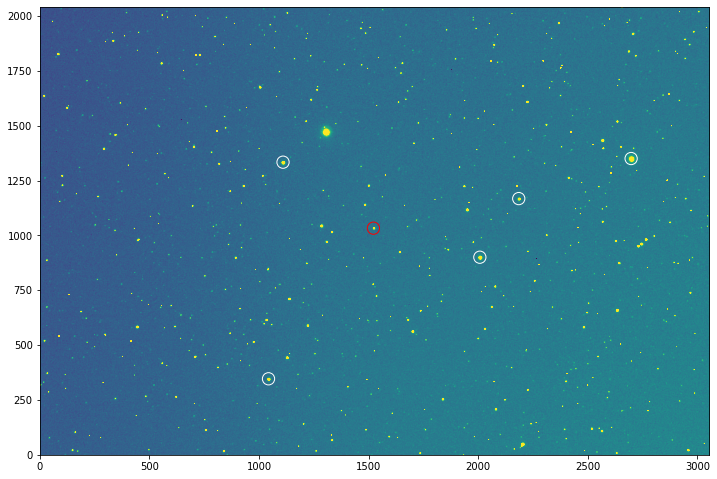

In [13]:
# Plot the whole image with the reference star and target star marked to see if it all looks ok

# Read in the data
sci_data, sci_hdr   = fits.getdata(image_list[0],header=True)

# Get the World Coordinate System (WCS) from the fits header. 
w                            = wcs.WCS(sci_hdr)

# Determine where to mark the reference stars in image coordinaes
xcoord_ref, ycoord_ref       = w.all_world2pix(ref_ra,ref_dec,1)
xcoord_target, ycoord_target = w.all_world2pix([target_RA],[target_DEC],1)

# Get the best vmin and vmax to visualize the image
interval = ZScaleInterval()
vmin     = interval.get_limits(sci_data)[0]
vmax     = interval.get_limits(sci_data)[1]
print('vmin: ',vmin)
print('vmax: ',vmax)

# Plot the figure
figure = plt.figure(figsize=(12,24))
plt.imshow(sci_data, vmin=vmin, vmax=vmax, origin='lower')

# Mark with a red circle the target stars. 
plt.scatter(xcoord_target,ycoord_target,marker='o',
            facecolors='none',s=150,linewidth=1,color='red')

# Mark with white circles the reference stars. 
plt.scatter(xcoord_ref,ycoord_ref,marker='o',
            facecolors='none',s=150,linewidth=1,color='white')

## Exercise / Question

Describe what you see in the figure above. What observation is this? When was this data taken and at what LCO site? How might you find out?

In [14]:
# Write code here which answers these questions

# 4. Calculate the magnitude of the target star in all B-band frames

Read through the code in the cell below and describe what takes place within the `for` loop. 

Then run the cell. Note: This cell may take a few minutes to run so be patient!

In [17]:
# Make some useful lists of values to track/record

obstime = [] # Time needed for x-axis 
Vmag    = [] # magnitude needed for y-axis
Vmag_e  = [] # magnitude error needed for y value error bar

# Loop through each frame and calculate and save the required values

for frame in image_list:
    # 1. Open the frame and read out the data, header and time of observation
    sci_data, sci_hdr   = fits.getdata(frame,header=True)
    time = sci_hdr['MJD-OBS']
    
    # Record the time of observation of this frame
    obstime.append(time)
    
    # 2. Get the background of the image and subtract it; 
    # Calculate the error associated with the background.
    sigma_clip = SigmaClip(sigma=3.) # Sigma clip bright obvious things to avoid biasing the background estimate
    bkg_estimator = SExtractorBackground() # Apply the SExtractor algorithm to our estimation
    bkg = Background2D(
        sci_data, (50, 50),
        filter_size=(3, 3),
        sigma_clip=sigma_clip,
        bkg_estimator=bkg_estimator)

    # Now let's subtract the background from the data
    sci_bkg = sci_data - bkg.background

    # Define an error image that will be used when calculating photometry
    effective_gain = 1.
    error = calc_total_error(sci_bkg, bkg.background_rms, effective_gain)
    
    # 3. For the target star and each reference star, carry out photometry. 
    # Be sure to use the background subtracted image. 
    # This step should output an error of the photmetry measurement. 
    
    # Calculate instrumental mags for each of the reference stars
    ref_instr_mag,ref_instr_mag_err = do_phot_get_mag(sci_bkg,sci_hdr,error,ref_ra,ref_dec)

    # Do photometry on the variable target
    tar_mag,tar_mag_err = do_phot_get_mag(sci_bkg,sci_hdr,error,target_RA,target_DEC)
    
    # 4. Find the magnitude offset between the reference stars 
    # and the catalog magnitudes 
    # and calculate the magnitude of the target star, and its error. 
    
    # Calculate offsets and the standard deviation of the offset from each star.
    offsets = []
    for i in range(len(ref_instr_mag)):
        offsets.append(ref_mag[i] - ref_instr_mag[i])
    offset = np.mean(offsets)
    offset_err = np.std(offsets)

    cal_tar_mag = tar_mag[0]+offset
    cal_tar_mag_err = np.sqrt(tar_mag_err[0]**2.+offset_err**2.)
    
    Vmag.append(cal_tar_mag)
    Vmag_e.append(cal_tar_mag_err)

## Exercise / Question

Next we'll use `pandas` to create a new dataframe/table to house your results contained within the `obstime`, `Vmag`, and `Vmag_err` lists.

In [19]:
# import pandas as pd
import pandas as pd
  
# We call the DataFrame constructor after zipping
# the three lists, with columns specified
results_df = pd.DataFrame(list(zip(obstime, Vmag, Vmag_e)),
               columns =['Observation Time', 'Vmag', 'Vmag_err'])
results_df

,Observation Time,Vmag,Vmag_err
0,58762.376095,12.738151,0.052681
1,58762.399475,12.775598,0.087790
2,58762.446717,13.232270,0.070320
3,58762.470258,13.271395,0.076492
4,58762.423088,12.991318,0.050967
5,58761.754015,13.100429,0.092029
6,58761.777997,13.350232,0.080737
7,58761.801260,13.314750,0.046502
8,58761.833619,12.980681,0.022709
9,58761.856604,12.857871,0.019041


It's often helpful to output our results to a .csv file. Read through the documentation for the `pandas` function `.to_csv` and write a command below which outputs this new results table to a .csv file.

The documentation for this can be found [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html).

In [20]:
results_df.to_csv(mypath+'results.csv', header=True)

# Making a Light Curve

It's now time to plot out these results! 🙌

## Exercise / Question

In a code cell below, write some code which creates a figure which plots the evolution of the magnitude of the star in V-band over time.

Make sure you label the axes and plot out the error for each datapoint.

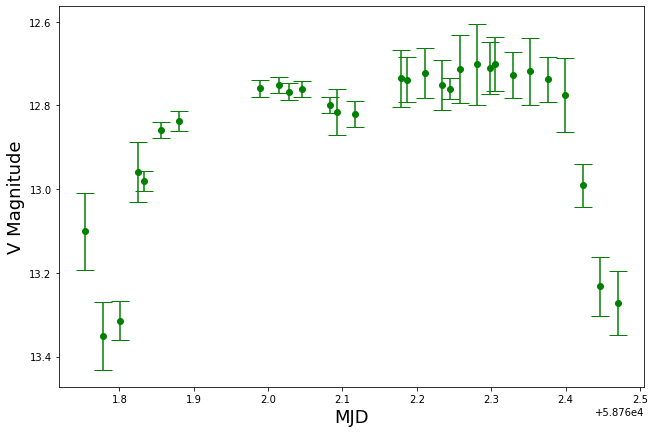

In [21]:
# # Make a rudimentary lightcurve

plt.figure(figsize=(10.5, 7))
plt.errorbar(obstime,Vmag,xerr=None,yerr=Vmag_e, fmt='go', capsize=9.0)
plt.xlabel('MJD', fontsize=18)
plt.ylabel('V Magnitude', fontsize=18)
plt.gca().invert_yaxis()
plt.show()

# 5. Constructing Cutouts

## Exercise / Question

Read through the code in the cell below and describe what takes place within the `for` loop. 

Then run the cell. Note: This cell may take a few minutes to run so be patient!

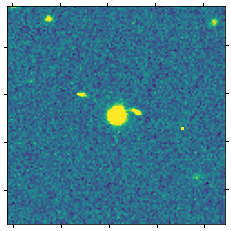

In [22]:
# Loop through each frame and calculate and save the required image

for frame in image_list:
    # 1. Open the frame and read out the data, header and time of observation
    # Read in file
    hdu = fits.open(frame)

    # Grab the actual science data based on above.
    sci_data = hdu[1]
    sci_hdr = sci_data.header
    time = sci_hdr['MJD-OBS']
    
    # Record the time of observation of this frame
    obstime.append(time)
    
    # 2. Get the background of the image and subtract it; 
    # Calculate the error associated with the background.
    sigma_clip = SigmaClip(sigma=3.) # Sigma clip bright obvious things to avoid biasing the background estimate
    bkg_estimator = SExtractorBackground() # Apply the SExtractor algorithm to our estimation
    bkg = Background2D(
        sci_data.data, (50, 50),
        filter_size=(3, 3),
        sigma_clip=sigma_clip,
        bkg_estimator=bkg_estimator)

    # Now let's subtract the background from the data
    sci_bkg = sci_data.data - bkg.background

    # Make tiny cutouts of the variable star in each frame
    cutout_hdu = make_cutout(sci_bkg,sci_hdr,target_RA,target_DEC)
    #cutout_hdu.writeto(frame+'_cutout.fits', overwrite=True)

    # Plot figures using these cutouts and output images
    interval = ZScaleInterval()
    vmin = interval.get_limits(cutout_hdu.data)[0]
    vmax = interval.get_limits(cutout_hdu.data)[1]

    plt.subplot(projection=wcs.WCS(cutout_hdu.header))
    plt.imshow(cutout_hdu.data, vmin=vmin, vmax=vmax, origin='lower')
    plt.xlabel('R.A.')
    plt.ylabel('Declination')

    # Save the small cutout as a png, with the file name as the time of observation. 
    # This can be used later to make a movie of your source
    pngname = str(time).replace('.','')
    plt.savefig(mypath+pngname+'.png', overwrite=True)

# Making a movie!

As a final step, let's stitch these images together to make a mini movie of your target and it's varying brightness on the night sky.

In [ ]:
# Here we are going to use the cutouts we made above to make
# an little movie of the variable star target changing brightness
# over time and loop it!

import imageio 

cutout_list = glob.glob(mypath+'*.png')
cutout_list.sort()

cutout_frames = []
for file in cutout_list:
    cutout_frames.append(imageio.imread(file))
imageio.mimsave(mypath+'mymovie.gif', cutout_frames)

# Wrapping Up

And.. that's it! Congratulations on completing the data analysis portion of the PASEA-ARP Program! 🎉🥳

The next step will be to work with your group mates to prepare a presentation on your findings. More details on this will be found on Slack!